This notebook contains all post-hoc analyses to summarize the results of CFpRF, DeepRF and the hybrid approach (the combination of DeepRF and CFpRF) on the empirical data. 

Author: Jordy Thielen (jordy.thielen@donders.ru.nl)

In [1]:
import os
import h5py
import numpy as np
import pandas as pd
from scipy.stats import pearsonr, wilcoxon
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import rc, rcParams
rcParams['font.sans-serif'] = "Arial"
rc('font',**{'family':'sans-serif','sans-serif':['Arial']})
rcParams['font.family'] = "sans-serif"
rcParams['pdf.fonttype'] = 42
fontsize = 14
rcParams.update(
    {'legend.fontsize': fontsize,
     'axes.labelsize': fontsize,
     'axes.titlesize': fontsize,
     'xtick.labelsize': fontsize,
     'ytick.labelsize': fontsize})


In [2]:
root = "/Users/jordythielen/2420084.01"
subjects = ["126426", "130114", "130518", "134627", "135124", "146735", "165436", "167440", "177140", "180533",
            "186949", "193845", "239136", "360030", "385046", "401422", "463040", "550439", "552241", "644246", 
            "654552", "757764", "765864", "878877", "905147", "943862", "971160", "973770", "995174"]
n_subjects = len(subjects)

alias = ("CFpRF", "DeepRF", "Hybrid")
models = ("cfprf", "resnet50_chan", "resnet50_chan_cfprf")
n_models = len(models)

parameters = ("delay", "sigma", "x", "y")
limits = [(-2, 2), (0, 8), (-8, 8), (-8, 8)]


In [3]:
# Read roi labels from atlas
rois = ["V1v", "V1d", "V2v", "V2d", "V3v", "V3d"]
with h5py.File(os.path.join(root, "derivatives", "analyseprf", "atlas.mat"), "r") as fid:
    atlas = np.array(fid["wang2015"]).astype("int").flatten()
    labels = ["".join(chr(c[0]) for c in fid[ref[0]]) for ref in fid["wang2015labels"]]
labels_idx = [i for i, lab in enumerate(labels) if lab in rois]
mask = np.full(atlas.size, False)
for lab in labels_idx:
    mask[atlas == lab] = True
atlas = atlas[mask]


In [4]:
# Extract data and put in dataframe

df = pd.DataFrame(columns=("subject", "voxel", "model", "explained variance", "ctime", 
                           "delay", "sigma", "x", "y", "eccen", "angle", "roi"))
i = 0
for i_subject, subject in enumerate(subjects):
    print(f"{1 + i_subject}, ", end="")

    for i_model, model in enumerate(models):

        tmp = np.load(os.path.join(root, "derivatives", model, "results_empirical_{}.npz".format(subject)))
        y_train = tmp["y_train"]
        r_valid = tmp["r_valid"]
        ctime = tmp["ctime"]
        n_voxels = ctime.size

        for i_voxel in range(n_voxels):
            voxel = "vox-{:02d}".format(1 + i_voxel)

            delay = y_train[i_voxel, 0]
            sigma = y_train[i_voxel, 1]
            x_pos = y_train[i_voxel, 2]
            y_pos = y_train[i_voxel, 3]

            eccen = np.sqrt(x_pos**2 + y_pos**2)
            angle = np.mod(np.arctan2(y_pos, x_pos), 2*np.pi)

            roi = rois[labels_idx.index(atlas[i_voxel])]

            df.loc[i] = [subject, voxel, model, r_valid[i_voxel], ctime[i_voxel],
                         delay, sigma, x_pos, y_pos, eccen, angle, roi]

            i += 1

df = df.round(3)

df.insert(10, "cut_eccen", pd.cut(df["eccen"], bins=np.arange(0, 11, 1)))

df.to_csv(os.path.join(root, "derivatives", "results.csv"))

print("done")


1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, done


In [5]:
# Filter out voxels of less than 15% explained variance in CFpRF

df15 = df.copy()
dropped = np.zeros((n_subjects))
for i_subject, subject in enumerate(subjects):

    voxels = df15[(df15["subject"] == subject) & (df15["model"] == "cfprf") & (df15["explained variance"] < 0.15)]["voxel"]
    dropped[i_subject] = voxels.size
    print("{} drops {:4d} of {} voxels".format(subject, voxels.size, n_voxels))

    df15 = df15.drop(df15[(df15["subject"] == subject) & (df15["voxel"].isin(list(voxels)))].index)

print("Dropped number of voxels: {:.1f} +/- {:.1f}".format(dropped.mean(), dropped.std()))


126426 drops  295 of 1968 voxels
130114 drops  370 of 1968 voxels
130518 drops  454 of 1968 voxels
134627 drops  376 of 1968 voxels
135124 drops  374 of 1968 voxels
146735 drops  293 of 1968 voxels
165436 drops  179 of 1968 voxels
167440 drops  409 of 1968 voxels
177140 drops  401 of 1968 voxels
180533 drops  340 of 1968 voxels
186949 drops 1141 of 1968 voxels
193845 drops  431 of 1968 voxels
239136 drops  290 of 1968 voxels
360030 drops  430 of 1968 voxels
385046 drops  307 of 1968 voxels
401422 drops  332 of 1968 voxels
463040 drops  306 of 1968 voxels
550439 drops  261 of 1968 voxels
552241 drops  563 of 1968 voxels
644246 drops  201 of 1968 voxels
654552 drops  382 of 1968 voxels
757764 drops  315 of 1968 voxels
765864 drops  290 of 1968 voxels
878877 drops  453 of 1968 voxels
905147 drops  379 of 1968 voxels
943862 drops  354 of 1968 voxels
971160 drops  328 of 1968 voxels
973770 drops  537 of 1968 voxels
995174 drops  621 of 1968 voxels
Dropped number of voxels: 393.5 +/- 170.9


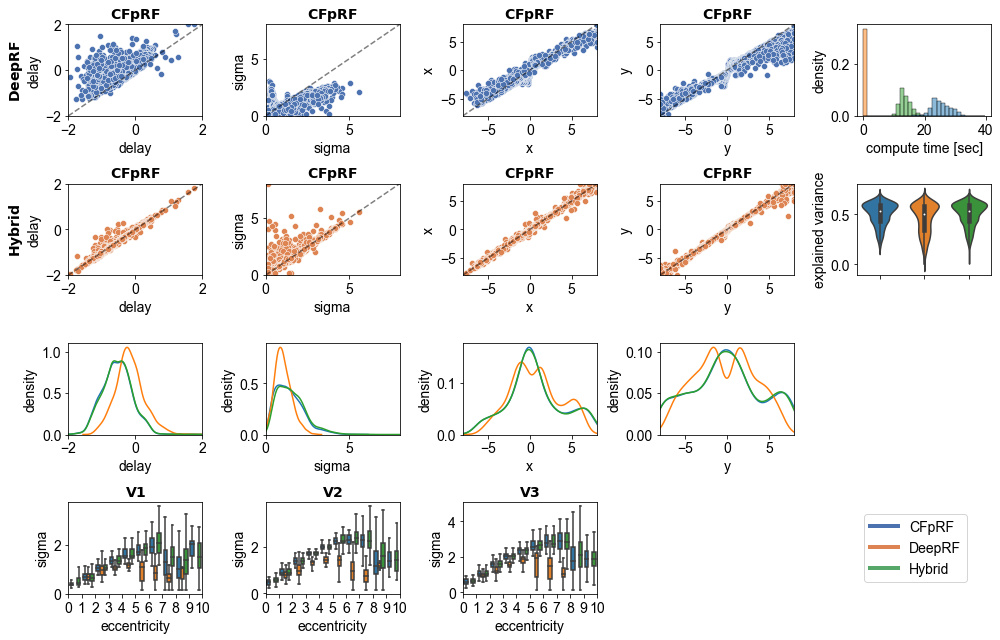

In [6]:
# Plot all data

df_ = df15.copy().groupby(["voxel", "model", "roi"]).mean().reset_index()
df_.insert(9, "cut_eccen", pd.cut(df_["eccen"], bins=np.arange(0, 11, 1)))

fig, axes = plt.subplots(4, 5, figsize=(14, 9))

colors = sns.color_palette("deep", n_models)
markers = ("o", "v", "^", "<", ">", "1", "2", "3", "4", "8", 
           "s", "p", "P", "*", "h", "H", "+", "x", "X", "d",
           "D", "|", "_", ".")

err_limits = ([-1, 1], [-3, 3], [-3, 3], [-3, 3])

for j, parameter in enumerate(parameters):
    axes[0,j].set_title(parameter)

for i, model in enumerate(["resnet50_chan", "resnet50_chan_cfprf"]):
    for j, parameter in enumerate(["delay", "sigma", "x", "y"]):
        ax = axes[i,j]
        ax.plot(limits[j], limits[j], color="k", linestyle="--", alpha=0.5)
        sns.scatterplot(x=df_[df_["model"] == "cfprf"][parameter].array, 
                        y=df_[df_["model"] == model][parameter].array, 
                        ax=ax, color=colors[i])
        ax.set_xlim(limits[j])
        ax.set_ylim(limits[j])
        ax.set_title("$\\bf{CFpRF}$")
        ax.set_xlabel(parameters[j])
        ax.set_ylabel(parameters[j])
axes[0,0].set_ylabel("$\\bf{DeepRF}$\ndelay")
axes[1,0].set_ylabel("$\\bf{Hybrid}$\ndelay")
    
for model in models:
    for j, param in enumerate(parameters):
        ax = axes[2,j]
        sns.kdeplot(data=df_[df_["model"] == model], x=param, ax=ax)
        ax.set_xlim(limits[j])
        ax.set_ylabel("density")
        ax.set_xlabel(param)
    
ax = axes[0,4]
sns.histplot(data=df_, x="ctime", hue="model", ax=ax, legend=False, stat="probability", bins=30)
ax.set_xlabel("compute time [sec]")
ax.set_ylabel("density")

ax = axes[1,4]
sns.violinplot(data=df_, x="model", y="explained variance", ax=ax)
ax.set_xticklabels([])
ax.set_xlabel("")
ax.set_ylabel("explained variance")
#ax.set_xticks(np.arange(n_models))
#ax.set_xticklabels(alias, rotation=45)

ax = axes[3,0]
g = sns.boxplot(data=df_[df_["roi"].isin(("V1d", "V1v"))], 
            x="cut_eccen", y="sigma", hue="model", showfliers=False, ax=ax)
g.legend_.remove()
ax.set_xticks(np.arange(-0.5, 10, 1))
ax.set_xticklabels(np.arange(0, 11, 1))
ax.set_xlabel("eccentricity")
ax.set_title("$\\bf{V1}$")

ax = axes[3,1]
g = sns.boxplot(data=df_[df_["roi"].isin(("V2d", "V2v"))], 
            x="cut_eccen", y="sigma", hue="model", showfliers=False, ax=ax)
g.legend_.remove()
ax.set_xticks(np.arange(-0.5, 10, 1))
ax.set_xticklabels(np.arange(0, 11, 1))
ax.set_xlabel("eccentricity")
ax.set_title("$\\bf{V2}$")

ax = axes[3,2]
g = sns.boxplot(data=df_[df_["roi"].isin(("V3d", "V3v"))], 
            x="cut_eccen", y="sigma", hue="model", showfliers=False, ax=ax)
g.legend_.remove()
ax.set_xticks(np.arange(-0.5, 10, 1))
ax.set_xticklabels(np.arange(0, 11, 1))
ax.set_xlabel("eccentricity")
ax.set_title("$\\bf{V3}$")

axes[2,4].axis('off')
axes[3,3].axis('off')

axes[3,4].axis('off')
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color=colors[0], lw=4),
                Line2D([0], [0], color=colors[1], lw=4),
                Line2D([0], [0], color=colors[2], lw=4)]
axes[3,4].legend(custom_lines, alias, loc="center left")

fig.tight_layout()

plt.savefig(os.path.join(root, "derivatives", "empirical_grandaverage.pdf"), dpi=300)


In [7]:
# Compute time

ctime_cfprf = np.zeros((n_subjects, n_voxels))
ctime_deeprf = np.zeros((n_subjects, n_voxels))
ctime_hybrid = np.zeros((n_subjects, n_voxels))
ctime_deeprf_gpu = np.zeros((n_subjects, n_voxels))

for i_subject, subject in enumerate(subjects):
    ctime_cfprf[i_subject, :] = np.load(os.path.join(root, "derivatives", "cfprf", "results_empirical_{}.npz".format(subject)))["ctime"]
    ctime_deeprf[i_subject, :] = np.load(os.path.join(root, "derivatives", "resnet50_chan", "results_empirical_{}.npz".format(subject)))["ctime"]
    ctime_hybrid[i_subject, :] = np.load(os.path.join(root, "derivatives", "resnet50_chan_cfprf", "results_empirical_{}.npz".format(subject)))["ctime"]
    ctime_deeprf_gpu[i_subject, :] = np.load(os.path.join(root, "derivatives", "resnet50_chan", "results_empirical_{}_batch.npz".format(subject)))["ctime"]

print("cfprf: {:.4f}".format(ctime_cfprf.mean()))
print("deeprf: {:.4f} ({:.1f})".format(ctime_deeprf.mean(), ctime_cfprf.mean() / ctime_deeprf.mean()))
print("hybrid: {:.4f} ({:.1f})".format(ctime_hybrid.mean(), ctime_cfprf.mean() / ctime_hybrid.mean()))
print("deeprf+gpu: {:.4f} ({:.1f})".format(ctime_deeprf_gpu.mean(), ctime_cfprf.mean() / ctime_deeprf_gpu.mean()))
    

cfprf: 25.2582
deeprf: 0.0442 (571.2)
hybrid: 13.4914 (1.9)
deeprf+gpu: 0.0004 (67951.9)


In [8]:
# Explained variance train

rtrn_cfprf = []
rtrn_deeprf = []
rtrn_hybrid = []

for i_subject, subject in enumerate(subjects):
    tmp = np.load(os.path.join(root, "derivatives", "cfprf", "results_empirical_{}.npz".format(subject)))["r_train"]
    idx = tmp > 0.15
    rtrn_cfprf.extend(tmp[idx])
    rtrn_deeprf.extend(np.load(os.path.join(root, "derivatives", "resnet50_chan", "results_empirical_{}.npz".format(subject)))["r_train"][idx])
    rtrn_hybrid.extend(np.load(os.path.join(root, "derivatives", "resnet50_chan_cfprf", "results_empirical_{}.npz".format(subject)))["r_train"][idx])

rtrn_cfprf = np.array(rtrn_cfprf)
rtrn_deeprf = np.array(rtrn_deeprf)
rtrn_hybrid = np.array(rtrn_hybrid)

print("mean and std")
print("cfprf: {:.3f} +\- {:.3f}".format(rtrn_cfprf.mean(), rtrn_cfprf.std()))
print("deeprf: {:.3f} +\- {:.3f}".format(rtrn_deeprf.mean(), rtrn_deeprf.std()))
print("hybrid: {:.3f} +/- {:.3f}".format(rtrn_hybrid.mean(), rtrn_hybrid.std()))

print("\ncfprf versus ... ")
print("cfprf vs deeprf: {:.3f}".format(wilcoxon(rtrn_cfprf, rtrn_deeprf, zero_method="zsplit")[1]))
print("cfprf vs hybrid: {:.3f}".format(wilcoxon(rtrn_cfprf, rtrn_hybrid, zero_method="zsplit")[1]))
    

mean and std
cfprf: 0.540 +\- 0.155
deeprf: 0.495 +\- 0.199
hybrid: 0.539 +/- 0.160

cfprf versus ... 
cfprf vs deeprf: 0.000
cfprf vs hybrid: 0.000


In [9]:
# Explained variance valid

rval_cfprf = []
rval_deeprf = []
rval_hybrid = []

for i_subject, subject in enumerate(subjects):
    tmp = np.load(os.path.join(root, "derivatives", "cfprf", "results_empirical_{}.npz".format(subject)))["r_valid"]
    idx = tmp > 0.15
    rval_cfprf.extend(tmp[idx])
    rval_deeprf.extend(np.load(os.path.join(root, "derivatives", "resnet50_chan", "results_empirical_{}.npz".format(subject)))["r_valid"][idx])
    rval_hybrid.extend(np.load(os.path.join(root, "derivatives", "resnet50_chan_cfprf", "results_empirical_{}.npz".format(subject)))["r_valid"][idx])

rval_cfprf = np.array(rval_cfprf)
rval_deeprf = np.array(rval_deeprf)
rval_hybrid = np.array(rval_hybrid)

print("mean and std")
print("cfprf: {:.3f} +\- {:.3f}".format(rval_cfprf.mean(), rval_cfprf.std()))
print("deeprf: {:.3f} +\- {:.3f}".format(rval_deeprf.mean(), rval_deeprf.std()))
print("hybrid: {:.3f} +/- {:.3f}".format(rval_hybrid.mean(), rval_hybrid.std()))

print("\ncfprf versus ... ")
print("cfprf vs deeprf: {:.3f}".format(wilcoxon(rval_cfprf, rval_deeprf, zero_method="zsplit")[1]))
print("cfprf vs hybrid: {:.3f}".format(wilcoxon(rval_cfprf, rval_hybrid, zero_method="zsplit")[1]))
    

mean and std
cfprf: 0.537 +\- 0.155
deeprf: 0.495 +\- 0.196
hybrid: 0.536 +/- 0.159

cfprf versus ... 
cfprf vs deeprf: 0.000
cfprf vs hybrid: 0.000


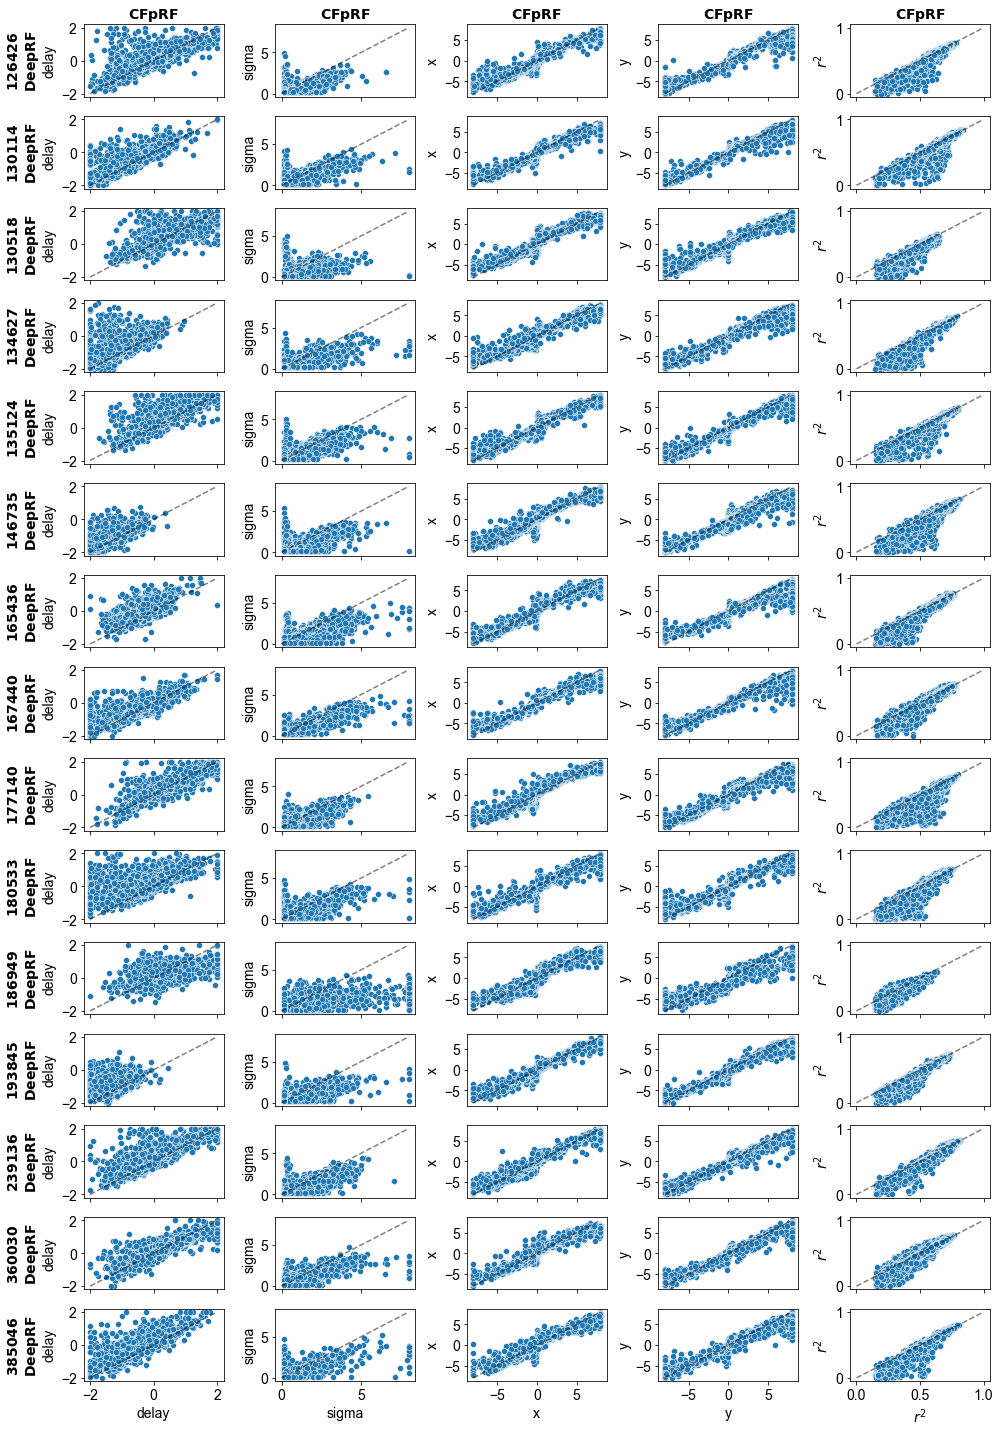

In [10]:
# Individual parameters and explained variance

df_ = df15
n = 15

fig, ax = plt.subplots(n, 5, figsize=(14, 20), sharex="col", sharey="col")

for i_subject, subject in enumerate(subjects[:n]):
    
    for i_param, param in enumerate(parameters):
        
        ax[i_subject, i_param].plot(limits[i_param], limits[i_param], color="k", linestyle="--", alpha=0.5)
        sns.scatterplot(ax=ax[i_subject, i_param],
            x=df_[(df_["subject"] == subject) & (df_["model"] == "cfprf")][param].array,
            y=df_[(df_["subject"] == subject) & (df_["model"] == "resnet50_chan")][param].array)

    ax[i_subject, 4].plot([0, 1], [0, 1], color="k", linestyle="--", alpha=0.5)
    sns.scatterplot(ax=ax[i_subject, 4],
            x=df_[(df_["subject"] == subject) & (df_["model"] == "cfprf")]["explained variance"].array,
            y=df_[(df_["subject"] == subject) & (df_["model"] == "resnet50_chan")]["explained variance"].array)
    
    ax[i_subject, 0].set_xlabel("delay")
    ax[i_subject, 1].set_xlabel("sigma")
    ax[i_subject, 2].set_xlabel("x")
    ax[i_subject, 3].set_xlabel("y")
    ax[i_subject, 4].set_xlabel("$r^2$")
    
    ax[i_subject, 0].set_ylabel("$\\bf{" + subject + "}$\n$\\bf{DeepRF}$\ndelay")
    ax[i_subject, 1].set_ylabel("sigma")
    ax[i_subject, 2].set_ylabel("x")
    ax[i_subject, 3].set_ylabel("y")
    ax[i_subject, 4].set_ylabel("$r^2$")
    
ax[0, 0].set_title("$\\bf{CFpRF}$")
ax[0, 1].set_title("$\\bf{CFpRF}$")
ax[0, 2].set_title("$\\bf{CFpRF}$")
ax[0, 3].set_title("$\\bf{CFpRF}$")
ax[0, 4].set_title("$\\bf{CFpRF}$")
    
fig.tight_layout()

plt.savefig(os.path.join(root, "derivatives", "empirical_individuals.pdf"), dpi=300)
    

In [11]:
# Parameter correlations

df_ = df15

print("CFpRF versus DeepRF")
r = np.zeros((n_subjects, 4))
for i_param, param in enumerate(parameters):
    for i_subject, subject in enumerate(subjects):
        r[i_subject, i_param] = pearsonr(
            df_[(df_["subject"] == subject) & (df_["model"] == "cfprf")][param].array,
            df_[(df_["subject"] == subject) & (df_["model"] == "resnet50_chan")][param].array)[0]
    print("\taverage r {}: {:.3f}".format(param, r[:, i_param].mean()))
    
print("CFpRF versus Hybrid")
r = np.zeros((n_subjects, 4))
for i_param, param in enumerate(parameters):
    for i_subject, subject in enumerate(subjects):
        r[i_subject, i_param] = pearsonr(
            df_[(df_["subject"] == subject) & (df_["model"] == "cfprf")][param].array,
            df_[(df_["subject"] == subject) & (df_["model"] == "resnet50_chan_cfprf")][param].array)[0]
    print("\taverage r {}: {:.3f}".format(param, r[:, i_param].mean()))
    

CFpRF versus DeepRF
	average r delay: 0.700
	average r sigma: 0.562
	average r x: 0.955
	average r y: 0.965
CFpRF versus Hybrid
	average r delay: 0.966
	average r sigma: 0.802
	average r x: 0.992
	average r y: 0.993
